In [1]:
import os
path=r"C:\Users\16106\Desktop\878 FILE"
os.chdir(path)

# Data Loading and Preprocessing

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Reading the files
admissions = pd.read_csv('admissions.csv')
diagnoses_icd = pd.read_csv('diagnoses_icd.csv')
d_icd_diagnoses = pd.read_csv('d_icd_diagnoses.csv')
prescriptions = pd.read_csv('prescriptions.csv')
patients = pd.read_csv('patients.csv')
triage_data = pd.read_csv('triage.csv')
edstays = pd.read_csv('edstays.csv')

C:\Users\16106\AppData\Local\Temp\ipykernel_34728\1800435220.py:9: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv('prescriptions.csv')


In [3]:
cancer_icd10_codes = diagnoses_icd[
    (diagnoses_icd['icd_version'] == 10) &
    (diagnoses_icd['icd_code'].str.startswith('C'))
]['icd_code'].unique()

cancer_related_keywords = ['neoplasm', 'tumor', 'malignancy', 'carcinoma', 'sarcoma', 'leukemia', 'lymphoma']
cancer_icd9_codes = d_icd_diagnoses[
    (d_icd_diagnoses['icd_version'] == 9) &
    (d_icd_diagnoses['long_title'].str.contains('|'.join(cancer_related_keywords), case=False, na=False))
]['icd_code'].unique()

cancer_codes = list(cancer_icd10_codes) + list(cancer_icd9_codes)

In [4]:
merged_pts = diagnoses_icd.merge(d_icd_diagnoses, on=['icd_code', 'icd_version'])
cancer_pts = merged_pts[merged_pts['icd_code'].str.startswith(tuple(cancer_codes), na=False)]
cancer_subjects = cancer_pts['subject_id'].unique()

In [5]:
num_cancer_subjects = len(cancer_subjects)
print(f"Number of cancer subjects: {num_cancer_subjects}")

Number of cancer subjects: 43649


In [6]:
c_cohort = patients[['subject_id', 'anchor_age', 'gender']].merge(
    admissions[['subject_id', 'race', 'insurance', 'marital_status', 'admission_type', 'language']],
    on='subject_id'
).drop_duplicates('subject_id')

c_cohort = c_cohort[c_cohort['subject_id'].isin(cancer_subjects)]

In [7]:
c_cohort

,subject_id,anchor_age,gender,race,insurance,marital_status,admission_type,language
13,10000560,53,F,WHITE,Private,MARRIED,SURGICAL SAME DAY ADMISSION,English
16,10000690,86,F,WHITE,Medicare,WIDOWED,EW EMER.,English
29,10000935,52,F,BLACK/AFRICAN AMERICAN,Medicare,SINGLE,EU OBSERVATION,English
34,10000947,60,M,BLACK/AFRICAN AMERICAN,Private,MARRIED,EW EMER.,English
44,10001186,46,F,WHITE,Private,MARRIED,SURGICAL SAME DAY ADMISSION,English
...,...,...,...,...,...,...,...,...
545976,19999287,71,F,BLACK/AFRICAN AMERICAN,Medicare,SINGLE,EW EMER.,English
545981,19999303,61,F,WHITE,Private,DIVORCED,DIRECT EMER.,English
545991,19999625,81,M,WHITE,Medicare,MARRIED,EW EMER.,Modern Greek (1453-)
545994,19999784,57,M,BLACK/AFRICAN AMERICAN,Medicaid,SINGLE,ELECTIVE,English


In [8]:
painkillers = [
    'Acetaminophen', 'Ibuprofen', 'Aspirin', 'Naproxen',
    'Codeine', 'Morphine', 'Fentanyl', 'Oxycodone',
    'Hydrocodone', 'Tramadol', 'Methadone', 'Hydromorphone',
    'Celecoxib', 'Diclofenac', 'Indomethacin', 'Ketorolac'
]

opioid_prescriptions = prescriptions[
    (prescriptions['subject_id'].isin(cancer_subjects)) &
    (prescriptions['drug'].isin(painkillers))
]

def calculate_prescription_features(df):
    features = {
        'total_prescriptions': len(df),
        'unique_drugs': df['drug'].nunique(),
        'avg_duration': (pd.to_datetime(df['stoptime']) -
                        pd.to_datetime(df['starttime'])).mean().days,
        'has_long_term': ((pd.to_datetime(df['stoptime']) -
                          pd.to_datetime(df['starttime'])).dt.days >= 90).any(),
        'drugs_used': list(df['drug'].unique())
    }
    return pd.Series(features)

patient_rx_features = opioid_prescriptions.groupby('subject_id').apply(calculate_prescription_features)

C:\Users\16106\AppData\Local\Temp\ipykernel_34728\1589076983.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  'avg_duration': (pd.to_datetime(df['stoptime']) -
C:\Users\16106\AppData\Local\Temp\ipykernel_34728\1589076983.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  'has_long_term': ((pd.to_datetime(df['stoptime']) -
C:\Users\16106\AppData\Local\Temp\ipykernel_34728\1589076983.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  'avg_duration': (pd.to_datetime(df['stoptime']) -
C:\Users\16106\AppData\Local\Temp\ipykernel_34728\1589076983.py:19: UserWarning: Could

In [9]:
patient_rx_features

,total_prescriptions,unique_drugs,avg_duration,has_long_term,drugs_used
subject_id,,,,,
10000560,2,2,1.0,False,"[Acetaminophen, Ketorolac]"
10000690,13,2,3.0,False,"[Acetaminophen, Aspirin]"
10000935,2,1,8.0,False,[Acetaminophen]
10000947,1,1,4.0,False,[Acetaminophen]
10001186,4,1,1.0,False,[Acetaminophen]
...,...,...,...,...,...
19999204,4,1,4.0,False,[Acetaminophen]
19999287,10,4,5.0,False,"[Acetaminophen, Ketorolac, Aspirin, Ibuprofen]"
19999303,3,2,3.0,False,"[Acetaminophen, Ketorolac]"


In [10]:
triage_data['pain'] = pd.to_numeric(triage_data['pain'], errors='coerce')

triage_data = triage_data.dropna(subset=['pain'])

triage_data.loc[triage_data['pain'] > 10, 'pain'] = 11

triage_data['pain']

0          7.0
1          0.0
2         10.0
3         10.0
4         11.0
          ... 
425081     0.0
425082     5.0
425083     8.0
425084     4.0
425085     0.0
Name: pain, Length: 396973, dtype: float64

In [11]:
pain_scores = triage_data[['subject_id', 'pain']].groupby('subject_id').agg(
    pain_mean=('pain', 'mean'),
    pain_max=('pain', 'max'),
    pain_count=('pain', 'count')
).reset_index()

In [12]:
pain_scores

,subject_id,pain_mean,pain_max,pain_count
0,10000032,7.600000,11.0,5
1,10000084,0.000000,0.0,2
2,10000108,5.000000,5.0,3
3,10000115,2.500000,5.0,2
4,10000117,4.666667,7.0,3
...,...,...,...,...
193188,19999733,0.000000,0.0,1
193189,19999750,10.000000,10.0,1
193190,19999784,1.666667,5.0,3
193191,19999828,6.000000,8.0,2


In [13]:
null_summary = pain_scores.isnull().sum()

for column, null_count in null_summary.items():
    percentage = (null_count / len(pain_scores)) * 100
    print(f"{column}: {null_count} null values ({percentage:.2f}% missing)")

subject_id: 0 null values (0.00% missing)
pain_mean: 0 null values (0.00% missing)
pain_max: 0 null values (0.00% missing)
pain_count: 0 null values (0.00% missing)


In [14]:
duplicates = pain_scores['subject_id'].duplicated().sum()
print(f"Number of duplicate subject_id: {duplicates}")


Number of duplicate subject_id: 0


In [15]:
analysis_df = c_cohort.merge(
    patient_rx_features,
    on='subject_id',
    how='inner'
).merge(
    pain_scores,
    on='subject_id',
    how='left'
)

In [16]:
analysis_df

,subject_id,anchor_age,gender,race,insurance,marital_status,admission_type,language,total_prescriptions,unique_drugs,avg_duration,has_long_term,drugs_used,pain_mean,pain_max,pain_count
0,10000560,53,F,WHITE,Private,MARRIED,SURGICAL SAME DAY ADMISSION,English,2,2,1.0,False,"[Acetaminophen, Ketorolac]",NaN,NaN,NaN
1,10000690,86,F,WHITE,Medicare,WIDOWED,EW EMER.,English,13,2,3.0,False,"[Acetaminophen, Aspirin]",NaN,NaN,NaN
2,10000935,52,F,BLACK/AFRICAN AMERICAN,Medicare,SINGLE,EU OBSERVATION,English,2,1,8.0,False,[Acetaminophen],2.000000,10.0,5.0
3,10000947,60,M,BLACK/AFRICAN AMERICAN,Private,MARRIED,EW EMER.,English,1,1,4.0,False,[Acetaminophen],NaN,NaN,NaN
4,10001186,46,F,WHITE,Private,MARRIED,SURGICAL SAME DAY ADMISSION,English,4,1,1.0,False,[Acetaminophen],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40547,19999204,61,M,WHITE,Medicare,SINGLE,OBSERVATION ADMIT,English,4,1,4.0,False,[Acetaminophen],7.000000,7.0,1.0
40548,19999287,71,F,BLACK/AFRICAN AMERICAN,Medicare,SINGLE,EW EMER.,English,10,4,5.0,False,"[Acetaminophen, Ketorolac, Aspirin, Ibuprofen]",0.000000,0.0,2.0
40549,19999303,61,F,WHITE,Private,DIVORCED,DIRECT EMER.,English,3,2,3.0,False,"[Acetaminophen, Ketorolac]",NaN,NaN,NaN
40550,19999784,57,M,BLACK/AFRICAN AMERICAN,Medicaid,SINGLE,ELECTIVE,English,31,1,4.0,False,[Acetaminophen],1.666667,5.0,3.0


In [17]:
duplicates = analysis_df['subject_id'].duplicated().sum()
print(f"Number of duplicate subject_id: {duplicates}")


Number of duplicate subject_id: 0


In [18]:
analysis_df = analysis_df.dropna(subset=['pain_mean', 'total_prescriptions'])

In [19]:
analysis_df

,subject_id,anchor_age,gender,race,insurance,marital_status,admission_type,language,total_prescriptions,unique_drugs,avg_duration,has_long_term,drugs_used,pain_mean,pain_max,pain_count
2,10000935,52,F,BLACK/AFRICAN AMERICAN,Medicare,SINGLE,EU OBSERVATION,English,2,1,8.0,False,[Acetaminophen],2.000000,10.0,5.0
5,10001217,55,F,WHITE,Private,MARRIED,EW EMER.,Other,3,1,4.0,False,[Acetaminophen],0.000000,0.0,2.0
6,10001401,89,F,WHITE,Medicare,MARRIED,OBSERVATION ADMIT,English,27,3,2.0,False,"[Acetaminophen, Ketorolac, Ibuprofen]",2.000000,8.0,4.0
8,10001725,46,F,WHITE,Private,MARRIED,EW EMER.,English,8,2,0.0,False,"[Ibuprofen, Ketorolac]",0.000000,0.0,1.0
10,10001860,84,M,WHITE,Medicare,MARRIED,EU OBSERVATION,English,3,1,1.0,False,[Acetaminophen],5.000000,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40544,19998562,79,M,WHITE,Medicare,MARRIED,DIRECT EMER.,English,2,1,5.0,False,[Acetaminophen],1.500000,3.0,2.0
40546,19998770,47,F,WHITE,Medicare,SINGLE,ELECTIVE,English,6,1,5.0,False,[Acetaminophen],0.000000,0.0,1.0
40547,19999204,61,M,WHITE,Medicare,SINGLE,OBSERVATION ADMIT,English,4,1,4.0,False,[Acetaminophen],7.000000,7.0,1.0
40548,19999287,71,F,BLACK/AFRICAN AMERICAN,Medicare,SINGLE,EW EMER.,English,10,4,5.0,False,"[Acetaminophen, Ketorolac, Aspirin, Ibuprofen]",0.000000,0.0,2.0


In [20]:
analysis_df.columns

Index(['subject_id', 'anchor_age', 'gender', 'race', 'insurance',
       'marital_status', 'admission_type', 'language', 'total_prescriptions',
       'unique_drugs', 'avg_duration', 'has_long_term', 'drugs_used',
       'pain_mean', 'pain_max', 'pain_count'],
      dtype='object')

In [21]:
age_bins = [0, 50, 70, 100]
age_labels = ['0-50', '51-70', '71-100']
analysis_df['age_group'] = pd.cut(analysis_df['anchor_age'], bins=age_bins, labels=age_labels)

C:\Users\16106\AppData\Local\Temp\ipykernel_34728\1833452272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['age_group'] = pd.cut(analysis_df['anchor_age'], bins=age_bins, labels=age_labels)


In [22]:
analysis_df['race'].unique()

array(['BLACK/AFRICAN AMERICAN', 'WHITE', 'OTHER', 'WHITE - RUSSIAN',
       'UNKNOWN', 'HISPANIC/LATINO - SALVADORAN',
       'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC OR LATINO',
       'BLACK/AFRICAN', 'WHITE - EASTERN EUROPEAN', 'ASIAN',
       'HISPANIC/LATINO - CUBAN', 'BLACK/CARIBBEAN ISLAND',
       'WHITE - OTHER EUROPEAN', 'ASIAN - CHINESE',
       'HISPANIC/LATINO - DOMINICAN', 'BLACK/CAPE VERDEAN',
       'HISPANIC/LATINO - CENTRAL AMERICAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - HONDURAN',
       'PATIENT DECLINED TO ANSWER', 'PORTUGUESE', 'ASIAN - ASIAN INDIAN',
       'AMERICAN INDIAN/ALASKA NATIVE', 'ASIAN - SOUTH EAST ASIAN',
       'WHITE - BRAZILIAN', 'SOUTH AMERICAN', 'UNABLE TO OBTAIN',
       'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - COLUMBIAN',
       'ASIAN - KOREAN', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
       'MULTIPLE RACE/ETHNICITY'], dtype=object)

In [ ]:
race_mapping = {
    'WHITE': 'White',
    'WHITE - RUSSIAN': 'White',
    'WHITE - OTHER EUROPEAN': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',
    'WHITE - BRAZILIAN': 'White',

    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/AFRICAN': 'Black',
    'BLACK/CARIBBEAN ISLAND': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',

    'HISPANIC OR LATINO': 'Hispanic',
    'HISPANIC/LATINO - CUBAN': 'Hispanic',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'Hispanic',
    'HISPANIC/LATINO - DOMINICAN': 'Hispanic',
    'HISPANIC/LATINO - GUATEMALAN': 'Hispanic',
    'HISPANIC/LATINO - PUERTO RICAN': 'Hispanic',
    'HISPANIC/LATINO - HONDURAN': 'Hispanic',
    'HISPANIC/LATINO - SALVADORAN': 'Hispanic',
    'HISPANIC/LATINO - MEXICAN': 'Hispanic',
    'HISPANIC/LATINO - COLUMBIAN': 'Hispanic',

    'ASIAN': 'Asian',
    'ASIAN - CHINESE': 'Asian',
    'ASIAN - ASIAN INDIAN': 'Asian',
    'ASIAN - SOUTH EAST ASIAN': 'Asian',
    'ASIAN - KOREAN': 'Asian',

    'AMERICAN INDIAN/ALASKA NATIVE': 'Other',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Other',
    'OTHER PACIFIC ISLANDER': 'Other',
    'UNKNOWN': 'Other',
    'UNABLE TO OBTAIN': 'Other',
    'PATIENT DECLINED TO ANSWER': 'Other',

    'OTHER': 'Other',
    'PORTUGUESE': 'Other',
    'SOUTH AMERICAN': 'Other',
    'MULTIPLE RACE/ETHNICITY': 'Other'
}

analysis_df['general_race'] = analysis_df['race'].map(race_mapping)

general_race_counts = analysis_df['general_race'].value_counts()
print(general_race_counts)


general_race
White       16892
Black        2954
Other        1404
Asian         916
Hispanic      891
Name: count, dtype: int64


C:\Users\16106\AppData\Local\Temp\ipykernel_34728\3818010976.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['general_race'] = analysis_df['race'].map(race_mapping)


In [24]:
analysis_df['general_race']

2        Black
5        White
6        White
8        White
10       White
         ...  
40544    White
40546    White
40547    White
40548    Black
40550    Black
Name: general_race, Length: 23057, dtype: object

In [25]:
opioid_drugs = [
    'codeine', 'morphine', 'fentanyl', 'oxycodone', 'hydrocodone',
    'tramadol', 'methadone', 'hydromorphone'
]

analysis_df['is_opioid'] = analysis_df['drugs_used'].apply(
    lambda drugs: 1 if any(drug.lower() in opioid_drugs for drug in drugs) else 0
)

C:\Users\16106\AppData\Local\Temp\ipykernel_34728\3002746136.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['is_opioid'] = analysis_df['drugs_used'].apply(


In [26]:
import pandas as pd

def encode_pain_level(pain_max):
    if 0 <= pain_max <= 2:
        return 1
    elif 2 < pain_max <= 5:
        return 2
    elif 5 < pain_max <= 8:
        return 3
    elif 8 < pain_max <= 11:
        return 4
    else:
        return None

analysis_df['pain_level_encode'] = analysis_df['pain_max'].apply(encode_pain_level)

print(analysis_df['pain_level_encode'])

2        4
5        1
6        3
8        1
10       2
        ..
40544    2
40546    1
40547    3
40548    1
40550    2
Name: pain_level_encode, Length: 23057, dtype: int64


C:\Users\16106\AppData\Local\Temp\ipykernel_34728\3104950608.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['pain_level_encode'] = analysis_df['pain_max'].apply(encode_pain_level)


# Data Analysis

In [27]:
analysis_df.to_csv('analysis_df.csv', index=False)

In [28]:
from statsmodels.stats.power import TTestIndPower

power_analysis = TTestIndPower()

effect_size = 0.5
alpha = 0.05
power = 0.8

race_groups = analysis_df['race'].unique()
power_results = []

for race in analysis_df['general_race'].unique():
    race_data = analysis_df[analysis_df['general_race'] == race]
    n = len(race_data)
    sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')
    power_results.append({
        "General Race": race,
        "Sample Size Needed": np.ceil(sample_size),
        "Actual Sample Size": n,
        "Meets Requirement": n >= np.ceil(sample_size)
        })
power_results_df = pd.DataFrame(power_results)

print(power_results_df)

  General Race  Sample Size Needed  Actual Sample Size  Meets Requirement
0        Black                64.0                2954               True
1        White                64.0               16892               True
2        Other                64.0                1404               True
3     Hispanic                64.0                 891               True
4        Asian                64.0                 916               True


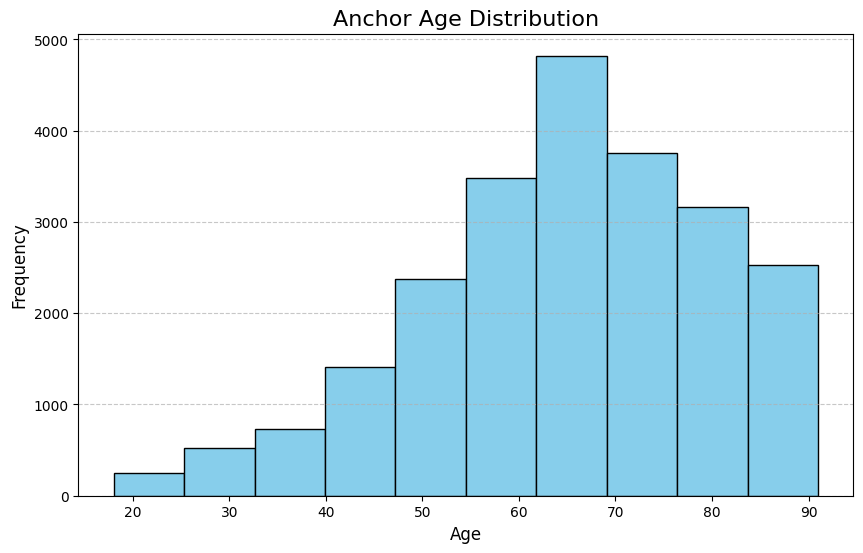

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
analysis_df['anchor_age'].plot(kind='hist', bins=10, color='skyblue', edgecolor='black')

plt.title('Anchor Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

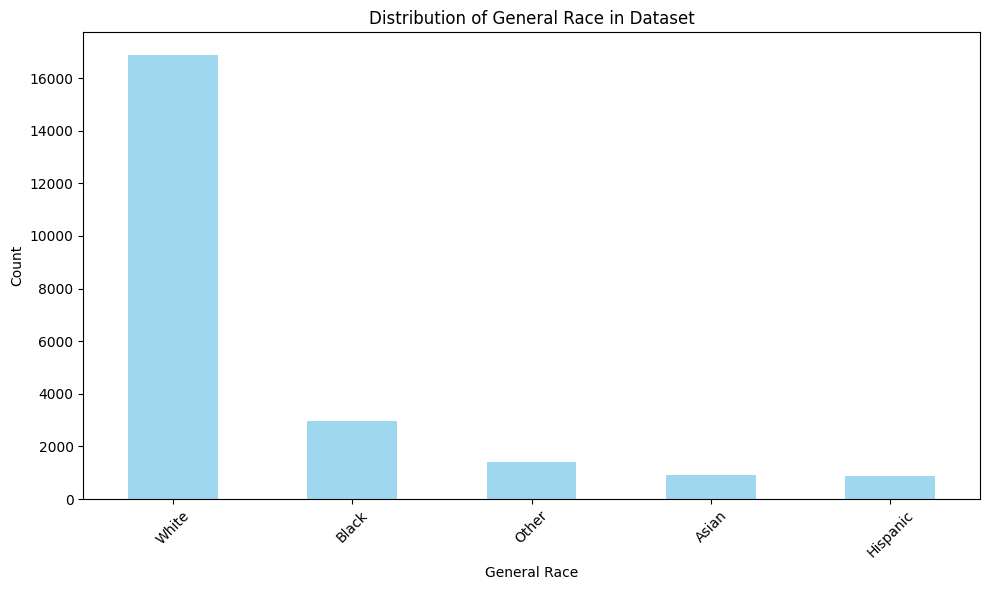

In [ ]:
import matplotlib.pyplot as plt

general_race_counts = analysis_df['general_race'].value_counts()
plt.figure(figsize=(10, 6))
general_race_counts.plot(kind='bar', color='skyblue', alpha=0.8)

plt.xlabel('General Race')
plt.ylabel('Count')
plt.title('Distribution of General Race in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [31]:
from scipy.stats import chi2_contingency

def chi_square_test_by_race(race, df):
    df['race_binary'] = df['general_race'].apply(lambda x: 'Current' if x == race else 'Other')
    contingency_table = pd.crosstab(df['race_binary'], df['is_opioid'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return {
        "Race": race,
        "Chi-squared": chi2,
        "P-value": p,
        "Degrees of Freedom": dof,
        "Expected Frequencies": expected
    }

races = analysis_df['general_race'].unique()
results = [chi_square_test_by_race(race, analysis_df) for race in races]
results_df = pd.DataFrame(results)

results_df


C:\Users\16106\AppData\Local\Temp\ipykernel_34728\961006975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['race_binary'] = df['general_race'].apply(lambda x: 'Current' if x == race else 'Other')
C:\Users\16106\AppData\Local\Temp\ipykernel_34728\961006975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['race_binary'] = df['general_race'].apply(lambda x: 'Current' if x == race else 'Other')
C:\Users\16106\AppData\Local\Temp\ipykernel_34728\961006975.py:4: SettingWithCopyWarning: 
A value is tr

,Race,Chi-squared,P-value,Degrees of Freedom,Expected Frequencies
0,Black,0.120707,0.728269,1,"[[2887.1227826690374, 66.8772173309624], [1964..."
1,White,0.986098,0.320698,1,"[[16509.57279784881, 382.4272021511905], [6025..."
2,Other,4.703394,0.030103,1,"[[1372.2140781541398, 31.78592184586026], [211..."
3,Hispanic,0.988378,0.320139,1,"[[870.8281649824348, 20.171835017565165], [216..."
4,Asian,4.384570,0.036266,1,"[[895.2621763455784, 20.73782365442165], [2163..."


In [32]:
opioid_usage = analysis_df.groupby('general_race')['is_opioid'].mean()
print(opioid_usage)

general_race
Asian       0.012009
Black       0.023697
Hispanic    0.028058
Other       0.031339
White       0.022022
Name: is_opioid, dtype: float64


In [33]:
pain_stats = analysis_df.groupby('general_race')[['pain_mean', 'pain_max', 'pain_count']].mean()
print(pain_stats)


              pain_mean  pain_max  pain_count
general_race                                 
Asian          3.951479  5.569869    2.643013
Black          4.157109  6.707007    5.156737
Hispanic       5.043170  7.360269    4.906846
Other          3.686420  5.058048    2.637464
White          3.322576  4.982649    3.107388


In [34]:
print(analysis_df['is_opioid'].value_counts())
print(analysis_df['is_opioid'].unique())


is_opioid
0    22535
1      522
Name: count, dtype: int64
[0 1]


In [35]:
race_opioid_usage = analysis_df.groupby('general_race')['is_opioid'].agg(['sum', 'count'])
race_opioid_usage['percentage'] = (race_opioid_usage['sum'] / race_opioid_usage['count'].astype(float)) * 100
print(race_opioid_usage)


              sum  count  percentage
general_race                        
Asian          11    916    1.200873
Black          70   2954    2.369668
Hispanic       25    891    2.805836
Other          44   1404    3.133903
White         372  16892    2.202226


In [ ]:
total_count = analysis_df.shape[0]

max_age = analysis_df['anchor_age'].max()
min_age = analysis_df['anchor_age'].min()
mean_age = analysis_df['anchor_age'].mean()

overall_gender_count = analysis_df['gender'].value_counts()
overall_gender_percent = (overall_gender_count / total_count) * 100

using_opioid = analysis_df[analysis_df['is_opioid'] == 1]
opioid_count = using_opioid.shape[0]

opioid_gender_count = using_opioid['gender'].value_counts()
opioid_gender_percent = (opioid_gender_count / opioid_count) * 100

not_using_opioid = analysis_df[analysis_df['is_opioid'] == 0]
non_opioid_count = not_using_opioid.shape[0]

non_opioid_gender_count = not_using_opioid['gender'].value_counts()
non_opioid_gender_percent = (non_opioid_gender_count / non_opioid_count) * 100

print(f"Total number of patients: {total_count}")
print(f"Maximum age: {max_age}")
print(f"Minimum age: {min_age}")
print(f"Mean age: {mean_age:.2f}\n")

print("Overall Male and Female Count and Percentage:")
print(f"Male: {overall_gender_count['M']} ({overall_gender_percent['M']:.2f}%)")
print(f"Female: {overall_gender_count['F']} ({overall_gender_percent['F']:.2f}%)\n")

print(f"Number of patients using opioids: {opioid_count}")
print("Male and Female Count and Percentage among opioid users:")
print(f"Male: {opioid_gender_count['M']} ({opioid_gender_percent['M']:.2f}%)")
print(f"Female: {opioid_gender_count['F']} ({opioid_gender_percent['F']:.2f}%)\n")

print(f"Number of patients not using opioids: {non_opioid_count}")
print("Male and Female Count and Percentage among non-opioid users:")
print(f"Male: {non_opioid_gender_count['M']} ({non_opioid_gender_percent['M']:.2f}%)")
print(f"Female: {non_opioid_gender_count['F']} ({non_opioid_gender_percent['F']:.2f}%)")


Total number of patients: 23057
Maximum age: 91
Minimum age: 18
Mean age: 64.99

Overall Male and Female Count and Percentage:
Male: 11089 (48.09%)
Female: 11968 (51.91%)

Number of patients using opioids: 522
Male and Female Count and Percentage among opioid users:
Male: 296 (56.70%)
Female: 226 (43.30%)

Number of patients not using opioids: 22535
Male and Female Count and Percentage among non-opioid users:
Male: 10793 (47.89%)
Female: 11742 (52.11%)


In [37]:
total_count = analysis_df.shape[0]

max_age = analysis_df['anchor_age'].max()
min_age = analysis_df['anchor_age'].min()
mean_age = analysis_df['anchor_age'].mean()

overall_race_count = analysis_df['general_race'].value_counts()
overall_race_percent = (overall_race_count / total_count) * 100

using_opioid = analysis_df[analysis_df['is_opioid'] == 1]
opioid_count = using_opioid.shape[0]

opioid_race_count = using_opioid['general_race'].value_counts()
opioid_race_percent = (opioid_race_count / opioid_count) * 100

not_using_opioid = analysis_df[analysis_df['is_opioid'] == 0]
non_opioid_count = not_using_opioid.shape[0]

non_opioid_race_count = not_using_opioid['general_race'].value_counts()
non_opioid_race_percent = (non_opioid_race_count / non_opioid_count) * 100

print(f"Total number of patients: {total_count}")
print(f"Maximum age: {max_age}")
print(f"Minimum age: {min_age}")
print(f"Mean age: {mean_age:.2f}\n")

print("Overall Race Count and Percentage:")
for race in overall_race_count.index:
    print(f"{race}: {overall_race_count[race]} ({overall_race_percent[race]:.2f}%)")

print(f"\nNumber of patients using opioids: {opioid_count}")
print("Race Count and Percentage among opioid users:")
for race in opioid_race_count.index:
    print(f"{race}: {opioid_race_count[race]} ({opioid_race_percent[race]:.2f}%)")

print(f"\nNumber of patients not using opioids: {non_opioid_count}")
print("Race Count and Percentage among non-opioid users:")
for race in non_opioid_race_count.index:
    print(f"{race}: {non_opioid_race_count[race]} ({non_opioid_race_percent[race]:.2f}%)")


Total number of patients: 23057
Maximum age: 91
Minimum age: 18
Mean age: 64.99

Overall Race Count and Percentage:
White: 16892 (73.26%)
Black: 2954 (12.81%)
Other: 1404 (6.09%)
Asian: 916 (3.97%)
Hispanic: 891 (3.86%)

Number of patients using opioids: 522
Race Count and Percentage among opioid users:
White: 372 (71.26%)
Black: 70 (13.41%)
Other: 44 (8.43%)
Hispanic: 25 (4.79%)
Asian: 11 (2.11%)

Number of patients not using opioids: 22535
Race Count and Percentage among non-opioid users:
White: 16520 (73.31%)
Black: 2884 (12.80%)
Other: 1360 (6.04%)
Asian: 905 (4.02%)
Hispanic: 866 (3.84%)


In [38]:
overall_pain_counts = analysis_df['pain_level_encode'].value_counts()
overall_pain_percentages = (overall_pain_counts / analysis_df.shape[0]) * 100

print("Overall Pain Level Encoded Counts and Percentages:")
for pain_level, count in overall_pain_counts.items():
    percentage = overall_pain_percentages[pain_level]
    print(f"Pain Level {pain_level}: Count = {count}, Percentage = {percentage:.2f}%")

using_opioid = analysis_df[analysis_df['is_opioid'] == 1]
opioid_pain_counts = using_opioid['pain_level_encode'].value_counts()
opioid_pain_percentages = (opioid_pain_counts / using_opioid.shape[0]) * 100

print("\nOpioid Pain Level Encoded Counts and Percentages:")
for pain_level, count in opioid_pain_counts.items():
    percentage = opioid_pain_percentages[pain_level]
    print(f"Pain Level {pain_level}: Count = {count}, Percentage = {percentage:.2f}%")

not_using_opioid = analysis_df[analysis_df['is_opioid'] == 0]
non_opioid_pain_counts = not_using_opioid['pain_level_encode'].value_counts()
non_opioid_pain_percentages = (non_opioid_pain_counts / not_using_opioid.shape[0]) * 100

print("\nNon-Opioid Pain Level Encoded Counts and Percentages:")
for pain_level, count in non_opioid_pain_counts.items():
    percentage = non_opioid_pain_percentages[pain_level]
    print(f"Pain Level {pain_level}: Count = {count}, Percentage = {percentage:.2f}%")

Overall Pain Level Encoded Counts and Percentages:
Pain Level 1: Count = 7495, Percentage = 32.51%
Pain Level 4: Count = 6704, Percentage = 29.08%
Pain Level 3: Count = 5183, Percentage = 22.48%
Pain Level 2: Count = 3675, Percentage = 15.94%

Opioid Pain Level Encoded Counts and Percentages:
Pain Level 4: Count = 293, Percentage = 56.13%
Pain Level 3: Count = 140, Percentage = 26.82%
Pain Level 1: Count = 58, Percentage = 11.11%
Pain Level 2: Count = 31, Percentage = 5.94%

Non-Opioid Pain Level Encoded Counts and Percentages:
Pain Level 1: Count = 7437, Percentage = 33.00%
Pain Level 4: Count = 6411, Percentage = 28.45%
Pain Level 3: Count = 5043, Percentage = 22.38%
Pain Level 2: Count = 3644, Percentage = 16.17%


In [ ]:
interaction_table = pd.crosstab(
    [analysis_df['general_race'], analysis_df['gender']],
    analysis_df['is_opioid'],
    margins=True
)

from statsmodels.stats.contingency_tables import StratifiedTable
from statsmodels.formula.api import logit

model = logit('is_opioid ~ general_race + gender + general_race:gender', data=analysis_df).fit()

def calculate_stratified_analysis():
    odds_ratios = {}
    for gender in ['F', 'M']:
        gender_data = analysis_df[analysis_df['gender'] == gender]
        gender_table = pd.crosstab(gender_data['general_race'], gender_data['is_opioid'])
        odds_ratios[gender] = gender_table.apply(lambda x: (x[1]/x[0]))
    return pd.DataFrame(odds_ratios)

print("Logistic Regression Results:")
print(model.summary())

print("\nOdds Ratios by Gender:")
print(calculate_stratified_analysis())

Optimization terminated successfully.
         Current function value: 0.107374
         Iterations 8
Logistic Regression Results:
                           Logit Regression Results                           
Dep. Variable:              is_opioid   No. Observations:                23057
Model:                          Logit   Df Residuals:                    23047
Method:                           MLE   Df Model:                            9
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                0.007098
Time:                        13:49:45   Log-Likelihood:                -2475.7
converged:                       True   LL-Null:                       -2493.4
Covariance Type:            nonrobust   LLR p-value:                 5.074e-05
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                  

C:\Users\16106\AppData\Local\Temp\ipykernel_34728\1993499572.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  odds_ratios[gender] = gender_table.apply(lambda x: (x[1]/x[0]))
C:\Users\16106\AppData\Local\Temp\ipykernel_34728\1993499572.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  odds_ratios[gender] = gender_table.apply(lambda x: (x[1]/x[0]))


In [40]:
analysis_df['race_gender'] = analysis_df['general_race'] + '_' + analysis_df['gender']
print(analysis_df['race_gender'].value_counts())

contingency_table = pd.crosstab(analysis_df['race_gender'], analysis_df['is_opioid'])
print(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared test statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

race_gender
White_F       8510
White_M       8382
Black_F       1777
Black_M       1177
Other_M        705
Other_F        699
Hispanic_F     511
Asian_F        471
Asian_M        445
Hispanic_M     380
Name: count, dtype: int64
is_opioid       0    1
race_gender           
Asian_F       465    6
Asian_M       440    5
Black_F      1732   45
Black_M      1152   25
Hispanic_F    502    9
Hispanic_M    364   16
Other_F       681   18
Other_M       679   26
White_F      8362  148
White_M      8158  224
Chi-squared test statistic: 36.15482200018496
P-value: 3.7215300988816074e-05
Degrees of freedom: 9
Expected frequencies:
[[ 460.33677408   10.66322592]
 [ 434.92540226   10.07459774]
 [1736.76952769   40.23047231]
 [1150.35325498   26.64674502]
 [ 499.43119226   11.56880774]
 [ 371.39697272    8.60302728]
 [ 683.17495771   15.82504229]
 [ 689.03912044   15.96087956]
 [8317.33746801  192.66253199]
 [8192.23532983  189.76467017]]


C:\Users\16106\AppData\Local\Temp\ipykernel_34728\1065430955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['race_gender'] = analysis_df['general_race'] + '_' + analysis_df['gender']


In [ ]:
analysis_df['race_insurance'] = analysis_df['general_race'] + '_' + analysis_df['insurance']
contingency_table = pd.crosstab(analysis_df['race_insurance'], analysis_df['is_opioid'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}, P-value: {p}")

Chi-squared: 201.81321191401474, P-value: 5.024144139095382e-31


C:\Users\16106\AppData\Local\Temp\ipykernel_34728\3840374706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['race_insurance'] = analysis_df['general_race'] + '_' + analysis_df['insurance']


In [ ]:
def analyze_racial_disparity_by_insurance(insurance_group):

    insurance_data = analysis_df[analysis_df['insurance'] == insurance_group]
    
    if insurance_data.empty:
        print(f"\nNo data available for Insurance: {insurance_group}")
        return None
    
    contingency = pd.crosstab(insurance_data['general_race'], insurance_data['is_opioid'])
    
    if contingency.empty or contingency.shape[1] < 2:
        print(f"\nInsufficient data for Insurance: {insurance_group}")
        return None
    
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    print(f"\nResults for Insurance: {insurance_group}")
    print("\nContingency Table:")
    print(contingency)
    print(f"\nChi-square statistic: {chi2:.2f}")
    print(f"P-value: {p:.5f}")
    print(f"Degrees of freedom: {dof}")

    percentages = (contingency[1] / (contingency[0] + contingency[1]) * 100).round(2)
    print("\nOpioid Prescription Rates by Race (%):")
    print(percentages)
    
    return {'contingency': contingency, 'chi2': chi2, 'p_value': p, 'percentages': percentages}

insurance_types = analysis_df['insurance'].unique()

insurance_results = {}

for insurance in insurance_types:
    result = analyze_racial_disparity_by_insurance(insurance)
    if result:
        insurance_results[insurance] = result



Results for Insurance: Medicare

Contingency Table:
is_opioid         0    1
general_race            
Asian           319    0
Black          1400   27
Hispanic        299    7
Other           656   16
White         10067  168

Chi-square statistic: 8.60
P-value: 0.07183
Degrees of freedom: 4

Opioid Prescription Rates by Race (%):
general_race
Asian       0.00
Black       1.89
Hispanic    2.29
Other       2.38
White       1.64
dtype: float64

Results for Insurance: Private

Contingency Table:
is_opioid        0    1
general_race           
Asian          258    3
Black          782   11
Hispanic       211    7
Other          429   10
White         4850  101

Chi-square statistic: 4.36
P-value: 0.36002
Degrees of freedom: 4

Opioid Prescription Rates by Race (%):
general_race
Asian       1.15
Black       1.39
Hispanic    3.21
Other       2.28
White       2.04
dtype: float64

Results for Insurance: Medicaid

Contingency Table:
is_opioid        0   1
general_race          
Asian        

In [ ]:
def analyze_racial_disparity_by_insurance(insurance_type):
    insurance_data = analysis_df[analysis_df['insurance'] == insurance_type]
    
    contingency = pd.crosstab(insurance_data['general_race'], insurance_data['is_opioid'])
    
    if not contingency.empty and contingency.sum().sum() > 0:
        chi2, p, dof, expected = chi2_contingency(contingency)
        
        print(f"\nResults for {insurance_type} Insurance:")
        print("\nContingency Table:")
        print(contingency)
        print(f"\nChi-square statistic: {chi2:.2f}")
        print(f"P-value: {p:.5f}")
        
        opioid_column = contingency.columns[contingency.columns.astype(str).str.contains('1', case=False, na=False)].tolist()
        non_opioid_column = contingency.columns[contingency.columns.astype(str).str.contains('0', case=False, na=False)].tolist()
        
        if opioid_column and non_opioid_column:
            opioid_column = opioid_column[0]
            non_opioid_column = non_opioid_column[0]
            
            percentages = (contingency[opioid_column] / (contingency[opioid_column] + contingency[non_opioid_column]) * 100).round(2)
            print("\nOpioid Prescription Rates (%):")
            print(percentages)
            
            return {'contingency': contingency, 'chi2': chi2, 'p_value': p, 'percentages': percentages}
        else:
            print("\nColumns for opioid prescription rates not found!")
            return None
    else:
        print(f"\nInsufficient data for {insurance_type} insurance")
        return None

insurance_types = analysis_df['insurance'].dropna().unique()

insurance_results = {}
for insurance in insurance_types:
    result = analyze_racial_disparity_by_insurance(insurance)
    if result:
        insurance_results[insurance] = result



Results for Medicare Insurance:

Contingency Table:
is_opioid         0    1
general_race            
Asian           319    0
Black          1400   27
Hispanic        299    7
Other           656   16
White         10067  168

Chi-square statistic: 8.60
P-value: 0.07183

Opioid Prescription Rates (%):
general_race
Asian       0.00
Black       1.89
Hispanic    2.29
Other       2.38
White       1.64
dtype: float64

Results for Private Insurance:

Contingency Table:
is_opioid        0    1
general_race           
Asian          258    3
Black          782   11
Hispanic       211    7
Other          429   10
White         4850  101

Chi-square statistic: 4.36
P-value: 0.36002

Opioid Prescription Rates (%):
general_race
Asian       1.15
Black       1.39
Hispanic    3.21
Other       2.28
White       2.04
dtype: float64

Results for Medicaid Insurance:

Contingency Table:
is_opioid        0   1
general_race          
Asian          304   7
Black          600  29
Hispanic       313  11
Othe

In [42]:
analysis_df['race_admission'] = analysis_df['general_race'] + '_' + analysis_df['admission_type']
contingency_table = pd.crosstab(analysis_df['race_admission'], analysis_df['is_opioid'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}, P-value: {p}")

Chi-squared: 81.60155526705167, P-value: 0.0004907222781687413


C:\Users\16106\AppData\Local\Temp\ipykernel_34728\1397265009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['race_admission'] = analysis_df['general_race'] + '_' + analysis_df['admission_type']


In [ ]:
def analyze_admission_disparity_by_type(admission_type):
    admission_data = analysis_df[analysis_df['admission_type'] == admission_type]
    
    contingency = pd.crosstab(admission_data['general_race'], admission_data['is_opioid'])
    
    if not contingency.empty and contingency.sum().sum() > 0:
        chi2, p, dof, expected = chi2_contingency(contingency)
        
        print(f"\nResults for Admission Type: {admission_type} and Race:")
        print("\nContingency Table:")
        print(contingency)
        print(f"\nChi-square statistic: {chi2:.2f}")
        print(f"P-value: {p:.5f}")
        
        opioid_column = contingency.columns[contingency.columns.astype(str).str.contains('1', case=False, na=False)].tolist()
        non_opioid_column = contingency.columns[contingency.columns.astype(str).str.contains('0', case=False, na=False)].tolist()
        
        if opioid_column and non_opioid_column:
            opioid_column = opioid_column[0]
            non_opioid_column = non_opioid_column[0]
            
            percentages = (contingency[opioid_column] / (contingency[opioid_column] + contingency[non_opioid_column]) * 100).round(2)
            print("\nOpioid Prescription Rates by Race (%):")
            print(percentages)
            
            return {'contingency': contingency, 'chi2': chi2, 'p_value': p, 'percentages': percentages}
        else:
            print("\nColumns for opioid prescription rates not found!")
            return None
    else:
        print(f"\nInsufficient data for Admission Type: {admission_type}")
        return None

admission_types = analysis_df['admission_type'].dropna().unique()

admission_results = {}
for admission in admission_types:
    result = analyze_admission_disparity_by_type(admission)
    if result:
        admission_results[admission] = result



Results for Admission Type: EU OBSERVATION and Race:

Contingency Table:
is_opioid        0   1
general_race          
Asian          105   2
Black          535  10
Hispanic       151   2
Other          130   2
White         2091  38

Chi-square statistic: 0.26
P-value: 0.99227

Opioid Prescription Rates by Race (%):
general_race
Asian       1.87
Black       1.83
Hispanic    1.31
Other       1.52
White       1.78
dtype: float64

Results for Admission Type: EW EMER. and Race:

Contingency Table:
is_opioid        0    1
general_race           
Asian          305    3
Black         1009   27
Hispanic       288    7
Other          458   14
White         6130  153

Chi-square statistic: 3.47
P-value: 0.48308

Opioid Prescription Rates by Race (%):
general_race
Asian       0.97
Black       2.61
Hispanic    2.37
Other       2.97
White       2.44
dtype: float64

Results for Admission Type: OBSERVATION ADMIT and Race:

Contingency Table:
is_opioid        0   1
general_race          
Asian     

In [43]:
analysis_df['pain_level'] = pd.cut(analysis_df['pain_mean'], bins=[0, 3, 6, 10], labels=['Low', 'Medium', 'High'])
analysis_df['race_pain'] = analysis_df['general_race'] + '_' + analysis_df['pain_level'].astype(str)
contingency_table = pd.crosstab(analysis_df['race_pain'], analysis_df['is_opioid'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}, P-value: {p}")

Chi-squared: 266.2428699962402, P-value: 1.56319031631445e-45


C:\Users\16106\AppData\Local\Temp\ipykernel_34728\2669743695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['pain_level'] = pd.cut(analysis_df['pain_mean'], bins=[0, 3, 6, 10], labels=['Low', 'Medium', 'High'])
C:\Users\16106\AppData\Local\Temp\ipykernel_34728\2669743695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['race_pain'] = analysis_df['general_race'] + '_' + analysis_df['pain_level'].astype(str)


In [ ]:
def analyze_racial_disparity_by_pain(pain_level):

    pain_data = analysis_df[analysis_df['pain_level'] == pain_level]
    
    contingency = pd.crosstab(pain_data['general_race'], pain_data['is_opioid'])
    
    if contingency.size > 0 and contingency.sum().sum() > 0:
        chi2, p, dof, expected = chi2_contingency(contingency)
        
        print(f"\nResults for Pain Level: {pain_level}")
        print("\nContingency Table:")
        print(contingency)
        print(f"\nChi-square statistic: {chi2:.2f}")
        print(f"P-value: {p:.5f}")
        
        percentages = (contingency[1] / (contingency[0] + contingency[1]) * 100).round(2)
        print("\nOpioid Prescription Rates (%):")
        print(percentages)
        
        return {
            'contingency': contingency,
            'chi2': chi2,
            'p_value': p,
            'percentages': percentages
        }
    else:
        print(f"\nInsufficient data for pain level {pain_level}")
        return None

pain_levels = analysis_df['pain_level'].unique()

pain_results = {}
for level in pain_levels:
    pain_results[level] = analyze_racial_disparity_by_pain(level)

print("\nSummary of Results:")
for level, results in pain_results.items():
    if results is not None:
        print(f"\nPain Level {level}:")
        print(f"Chi-square: {results['chi2']:.2f}")
        print(f"P-value: {results['p_value']:.5f}")


Results for Pain Level: Low

Contingency Table:
is_opioid        0   1
general_race          
Asian          197   1
Black          590   4
Hispanic       122   2
Other          254   5
White         3989  47

Chi-square statistic: 3.58
P-value: 0.46570

Opioid Prescription Rates (%):
general_race
Asian       0.51
Black       0.67
Hispanic    1.61
Other       1.93
White       1.16
dtype: float64

Insufficient data for pain level nan

Results for Pain Level: Medium

Contingency Table:
is_opioid        0    1
general_race           
Asian          257    4
Black          967   31
Hispanic       263   10
Other          358   17
White         4382  117

Chi-square statistic: 7.44
P-value: 0.11427

Opioid Prescription Rates (%):
general_race
Asian       1.53
Black       3.11
Hispanic    3.66
Other       4.53
White       2.60
dtype: float64

Results for Pain Level: High

Contingency Table:
is_opioid        0    1
general_race           
Asian          190    5
Black          724   33
Hispan

1. Stratified Analysis by Pain Level:

Pain Level: Low
Contingency Table:
is_opioid        0   1
general_race          
Asian          197   1
Black          590   4
Hispanic       122   2
Other          254   5
White         3989  47
Chi-square: 3.58
P-value: 0.46570
Prescription Rates (%):
general_race
Asian       0.51
Black       0.67
Hispanic    1.61
Other       1.93
White       1.16
dtype: float64

Pain Level: Medium
Contingency Table:
is_opioid        0    1
general_race           
Asian          257    4
Black          967   31
Hispanic       263   10
Other          358   17
White         4382  117
Chi-square: 7.44
P-value: 0.11427
Prescription Rates (%):
general_race
Asian       1.53
Black       3.11
Hispanic    3.66
Other       4.53
White       2.60
dtype: float64

Pain Level: High
Contingency Table:
is_opioid        0    1
general_race           
Asian          190    5
Black          724   33
Hispanic       338   13
Other          280   15
White         2842  159
Chi-square:

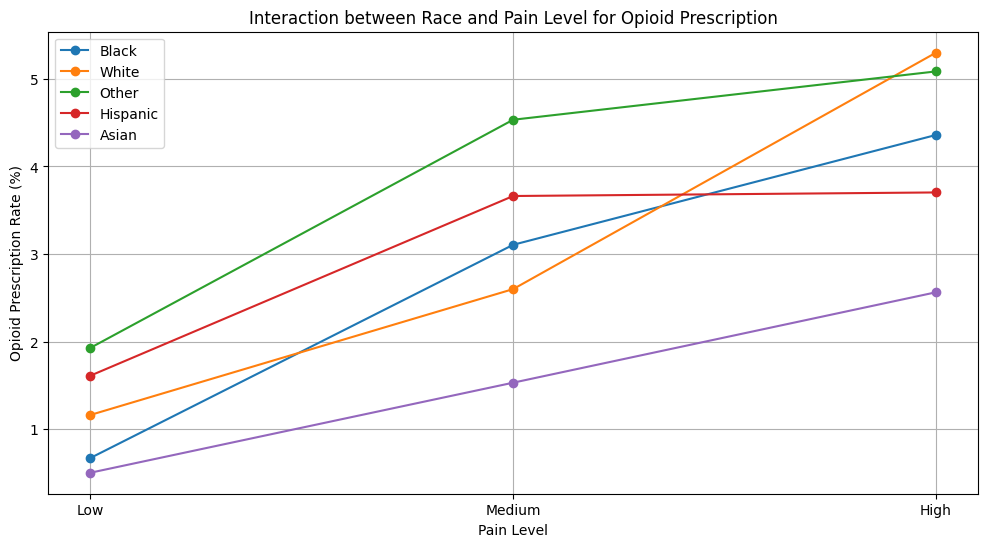

In [ ]:
def analyze_racial_disparity_by_pain(pain_level):
    pain_data = analysis_df[analysis_df['pain_level'] == pain_level]
    contingency = pd.crosstab(pain_data['general_race'], pain_data['is_opioid'])
    
    if contingency.size > 0 and contingency.sum().sum() > 0:
        chi2, p, dof, expected = chi2_contingency(contingency)
        percentages = (contingency[1] / (contingency[0] + contingency[1]) * 100).round(2)
        return {
            'contingency': contingency,
            'chi2': chi2,
            'p_value': p,
            'percentages': percentages
        }
    return None

def analyze_race_pain_interaction():
    three_way_table = pd.crosstab(
        [analysis_df['general_race'], analysis_df['pain_level']],
        analysis_df['is_opioid']
    )
    
    from statsmodels.formula.api import logit
    model = logit('is_opioid ~ general_race + pain_level + general_race:pain_level', 
                  data=analysis_df).fit()
    
    return {
        'contingency': three_way_table,
        'model': model
    }

print("1. Stratified Analysis by Pain Level:")

pain_levels = sorted(
    [level for level in analysis_df['pain_level'].dropna().unique()],
    key=lambda x: ['Low', 'Medium', 'High'].index(str(x))  # 确保按分类排序
)

stratified_results = {level: analyze_racial_disparity_by_pain(level) 
                     for level in pain_levels}

for level, results in stratified_results.items():
    if results is not None:
        print(f"\nPain Level: {level}")
        print("Contingency Table:")
        print(results['contingency'])
        print(f"Chi-square: {results['chi2']:.2f}")
        print(f"P-value: {results['p_value']:.5f}")
        print("Prescription Rates (%):")
        print(results['percentages'])

print("\n2. Race-Pain Level Interaction Analysis:")

interaction_results = analyze_race_pain_interaction()

print("\nThree-way Contingency Table:")
print(interaction_results['contingency'])
print("\nLogistic Regression Results (including interaction terms):")
print(interaction_results['model'].summary())

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for race in analysis_df['general_race'].unique():
    race_data = analysis_df[analysis_df['general_race'] == race]
    rates = []
    for level in pain_levels:
        level_data = race_data[race_data['pain_level'] == level]
        if not level_data.empty:
            rate = level_data['is_opioid'].mean() * 100
        else:
            rate = 0
        rates.append(rate)
    plt.plot(pain_levels, rates, marker='o', label=race)

plt.title('Interaction between Race and Pain Level for Opioid Prescription')
plt.xlabel('Pain Level')
plt.ylabel('Opioid Prescription Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import scipy.stats as stats

contingency_table = pd.crosstab(analysis_df['general_race'], analysis_df['is_opioid'])

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("Contingency Table:")
print(contingency_table)

print("\nChi-square Test Results:")
print(f"Chi2 Statistic: {chi2:.2f}")
print(f"P-value: {p:.5f}")
print(f"Degrees of Freedom: {dof}")
print("\nExpected Frequencies Table:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

if p < 0.05:
    print("\nResult: Statistically significant association between race and opioid use (p < 0.05).")
else:
    print("\nResult: No statistically significant association between race and opioid use (p >= 0.05).")


Contingency Table:
is_opioid         0    1
general_race            
Asian           905   11
Black          2884   70
Hispanic        866   25
Other          1360   44
White         16520  372

Chi-square Test Results:
Chi2 Statistic: 11.10
P-value: 0.02543
Degrees of Freedom: 4

Expected Frequencies Table:
is_opioid                0           1
general_race                          
Asian           895.262176   20.737824
Black          2887.122783   66.877217
Hispanic        870.828165   20.171835
Other          1372.214078   31.785922
White         16509.572798  382.427202

Result: Statistically significant association between race and opioid use (p < 0.05).


In [ ]:
def analyze_racial_disparity_by_gender(gender_group):

    gender_data = analysis_df[analysis_df['gender'] == gender_group]
    
    contingency = pd.crosstab(gender_data['general_race'], gender_data['is_opioid'])
    
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    print(f"\nResults for {gender_group}:")
    print("\nContingency Table:")
    print(contingency)
    print(f"\nChi-square statistic: {chi2:.2f}")
    print(f"P-value: {p:.5f}")
    print(f"Degrees of freedom: {dof}")
    
    percentages = (contingency[1] / (contingency[0] + contingency[1]) * 100).round(2)
    print("\nOpioid Prescription Rates (%):")
    print(percentages)
    
    return {'contingency': contingency, 'chi2': chi2, 'p_value': p, 'percentages': percentages}

female_results = analyze_racial_disparity_by_gender('F')
male_results = analyze_racial_disparity_by_gender('M')


Results for F:

Contingency Table:
is_opioid        0    1
general_race           
Asian          465    6
Black         1732   45
Hispanic       502    9
Other          681   18
White         8362  148

Chi-square statistic: 7.78
P-value: 0.09980
Degrees of freedom: 4

Opioid Prescription Rates (%):
general_race
Asian       1.27
Black       2.53
Hispanic    1.76
Other       2.58
White       1.74
dtype: float64

Results for M:

Contingency Table:
is_opioid        0    1
general_race           
Asian          440    5
Black         1152   25
Hispanic       364   16
Other          679   26
White         8158  224

Chi-square statistic: 11.73
P-value: 0.01948
Degrees of freedom: 4

Opioid Prescription Rates (%):
general_race
Asian       1.12
Black       2.12
Hispanic    4.21
Other       3.69
White       2.67
dtype: float64


In [ ]:
from statsmodels.stats.power import TTestIndPower
import numpy as np
import pandas as pd

power_analysis = TTestIndPower()

effect_size = 0.5
alpha = 0.05 
power = 0.8       

power_results = []

gender_groups = analysis_df['gender'].unique()

for gender in gender_groups:
    gender_data = analysis_df[analysis_df['gender'] == gender]
    n = len(gender_data)
    sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')
    power_results.append({
        "Gender": gender,
        "Sample Size Needed": np.ceil(sample_size),
        "Actual Sample Size": n,
        "Meets Requirement": n >= np.ceil(sample_size)
    })

power_results_df = pd.DataFrame(power_results)

# 打印结果
print(power_results_df)


  Gender  Sample Size Needed  Actual Sample Size  Meets Requirement
0      F                64.0               11968               True
1      M                64.0               11089               True


In [55]:
analysis_df.columns

Index(['subject_id', 'anchor_age', 'gender', 'race', 'insurance',
       'marital_status', 'admission_type', 'language', 'total_prescriptions',
       'unique_drugs', 'avg_duration', 'has_long_term', 'drugs_used',
       'pain_mean', 'pain_max', 'pain_count', 'age_group', 'general_race',
       'is_opioid', 'pain_level_encode', 'race_binary', 'race_gender',
       'race_insurance', 'race_admission', 'pain_level', 'race_pain'],
      dtype='object')

In [ ]:
medicaid_data = analysis_df[analysis_df['insurance'] == 'Medicaid']

results = []
for race in medicaid_data['general_race'].unique():
    current_race = medicaid_data[medicaid_data['general_race'] == race]
    other_races = medicaid_data[medicaid_data['general_race'] != race]
    
    contingency_table = [
        [current_race['is_opioid'].value_counts().get(0, 0), current_race['is_opioid'].value_counts().get(1, 0)],
        [other_races['is_opioid'].value_counts().get(0, 0), other_races['is_opioid'].value_counts().get(1, 0)]
    ]
    
    chi2, p, _, _ = chi2_contingency(contingency_table)
    results.append({"Race": race, "Chi-Square": chi2, "P-Value": p})

results_df = pd.DataFrame(results)
print(results_df)

       Race  Chi-Square   P-Value
0     Other    1.157629  0.281958
1  Hispanic    2.471742  0.115909
2     White    7.716995  0.005470
3     Asian    6.125821  0.013322
4     Black    0.817725  0.365846


In [ ]:
observation_admit_data = analysis_df[analysis_df['admission_type'] == 'OBSERVATION ADMIT']

results = []
for race in observation_admit_data['general_race'].unique():
    current_race = observation_admit_data[observation_admit_data['general_race'] == race]
    other_races = observation_admit_data[observation_admit_data['general_race'] != race]
    
    contingency_table = [
        [current_race['is_opioid'].value_counts().get(0, 0), current_race['is_opioid'].value_counts().get(1, 0)],
        [other_races['is_opioid'].value_counts().get(0, 0), other_races['is_opioid'].value_counts().get(1, 0)]
    ]
    
    chi2, p, _, _ = chi2_contingency(contingency_table)
    results.append({"Race": race, "Chi-Square": chi2, "P-Value": p})

results_df = pd.DataFrame(results)
print(results_df)

       Race  Chi-Square   P-Value
0     White    3.731146  0.053407
1  Hispanic    1.364087  0.242830
2     Black    1.648363  0.199182
3     Other    2.986638  0.083954
4     Asian    1.169127  0.279581
